In [17]:
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import sklearn

In [416]:
series = read_csv('daily-minimum-temperatures.csv', header=0)

In [436]:
series = read_csv('str_1375.csv', header=0)
series=series['temp_bkrm_space_dept_clas.cubic_vol']

In [437]:
X = series
size = len(X) - 90
train, test = X[0:size], X[size:]

### Method 1: Using statmodels but not using model_fit.forecast()

In [234]:
history = [float(x) for x in train]
t = [x[0] for x in test]
predictions = list()

def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	diff = difference(history)
	yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('>predicted=%.3f, expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

>predicted=10.600, expected=11.800
>predicted=10.920, expected=12.800
>predicted=11.627, expected=11.600
>predicted=10.972, expected=10.600
>predicted=10.397, expected=9.800
>predicted=9.913, expected=11.200
>predicted=10.780, expected=5.700
Test RMSE: 2.169


### Method 2: Using statmodels WITH model_fit.forecast()

In [237]:
history = [float(x) for x in train]
t = [x[0] for x in test]
predictions = list()

model = ARIMA(history, order=(1,1,1))
model_fit = model.fit(trend='nc', disp=False)
yh = model_fit.forecast(steps=7)[0]
print(np.array(yh))
print(t)
np.sqrt(np.mean((yh-t)**2))

[10.59965899 10.16973883  9.93879809  9.81474337  9.74810474  9.71230839
  9.69307962]
[11.8, 12.8, 11.6, 10.6, 9.8, 11.2, 5.7]


2.0666023323793814

### Method 2: Using statmodels WITH model_fit.forecast() and use brute optimization for p, d, q

In [242]:
history = [float(x) for x in train]
endog = history

In [248]:
def objfunc(order, endog):
    from statsmodels.tsa.arima_model import ARIMA
    print("Order..")
    print(order)
    fit = ARIMA(endog, order).fit(trend='nc', disp=False)
    print("AIC..")
    print(fit.aic)
    return fit.aic

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
brute(objfunc, grid, args=([endog]), finish=None)

Order..
[1 1 1]
AIC..
708.4071840680302
Order..
[1 1 1]
AIC..
708.4071840680302
Order..
[1 1 2]
AIC..
706.472080655936
Order..
[1 2 1]


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

### ARIMA without package

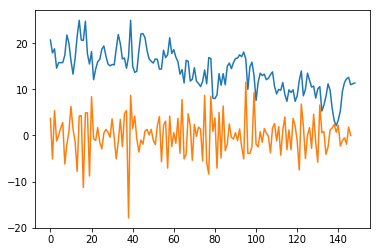

In [280]:
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

def difference_1(dataset, interval=1):
    for d in range(1, interval+1):
        diff = list()
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        dataset = diff
    return diff


def ar(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff



history = [float(x) for x in train]
plt.plot(history)
diff = difference_1(history, 2)
plt.plot(diff)

### ARIMA using Pyramid

In [10]:
series = read_csv('str_1375.csv', header=0)
series=series['temp_bkrm_space_dept_clas.cubic_vol']
# series = read_csv('daily-minimum-temperatures.csv', header=0)

X = series
size = len(X) - 30
train, test = X[120:size], X[size:]
train=train.values

In [11]:
len(train)

939

In [12]:
len(test)

30

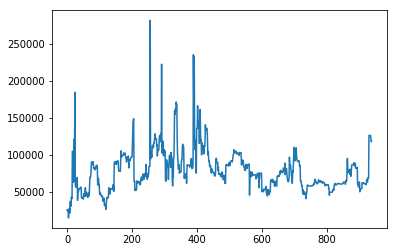

In [13]:
plt.plot(train)

In [501]:
?auto_arima

In [19]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train, m=365,
                            seasonal=True,
#                             start_p=6, max_p=6, start_q=1, max_q=1, start_P=6, max_P=6, start_Q=1, max_Q=1, max_order=20,
                            d=1, D=1, 
                            error_action='ignore', suppress_warnings=True, stepwise = True)
print(stepwise_model.aic())

KeyboardInterrupt: 

In [775]:
print(len(train))
for i in range(4):
    print(i)
    stepwise_model = auto_arima(train, m=13, 
                                seasonal=True,
                                start_p=6, max_p=6, start_q=1, max_q=1, start_P=6, max_P=6, start_Q=1, max_Q=1, max_order=20,
                                d=1, D=1,
                                suppress_warnings=True, stepwise = True, error_action='ignore',)
    print(stepwise_model.predict(n_periods=13))
    f = stepwise_model.predict(n_periods=13)
    ff = [[x] for x in f]
    print(ff)
    train = np.append(train, ff, axis=0)
    print(len(train))


104
0
[14.51475648 12.44262883 11.54110103 11.15567259 12.6279992  11.41035298
 12.57901559 12.69693672 12.00211333 10.74467202 10.9249283   9.96804221
 11.94933764]
[[14.514756483910084], [12.442628832397705], [11.541101026071338], [11.155672591659881], [12.627999200838914], [11.410352981841054], [12.57901559287215], [12.696936722884134], [12.002113334183429], [10.744672015189831], [10.924928301889615], [9.968042209116064], [11.949337639290817]]
117
1


KeyboardInterrupt: 

In [ ]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train, m=120, 
                            seasonal=True,
                            d=1, D=1,
                            suppress_warnings=True, stepwise = True, error_action='ignore',)
# stepwise_model = auto_arima(train, start_p=1, start_q=1,
#                            max_p=3, max_q=3, m=52,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
print(stepwise_model.aic())

In [15]:
forecast = stepwise_model.predict(n_periods=len(test))
# forecast = train[-52:]
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

RMSE... 63662.47280839184
MAPE.. 1.3484538097523608


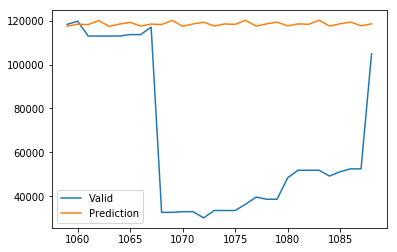

In [18]:
#plot the predictions for validation set
# plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend()
RMSE = np.sqrt(np.mean(np.square(np.subtract(test.values,forecast.values))))
print("RMSE...", RMSE)
MAPE = np.mean(abs(np.subtract(test.values,forecast.values)/test.values))
print("MAPE..", MAPE)

In [471]:

from pmdarima.arima import auto_arima

class arima():
    def __init__(self, y, n_periods, seasonal=False, exogenous=None, start_p=1,
                 start_P=1, start_q=1, start_Q=1, d=1, D=1, m=1,
                 suppress_warnings=True, exog_pred=None):
        self.y = y
        self.seasonal = seasonal
        self.exogenous = exogenous
        self.start_p = start_p
        self.start_P = start_P
        self.start_q = start_q
        self.start_Q = start_Q
        self.d = d
        self.D = D
        self.m = m
        self.n_periods = n_periods
        self.suppress_warnings = suppress_warnings
        self.exog_pred = exog_pred

    def _preprocess(self):
        pass

    def fit(self):
        self.model = auto_arima(y=self.y
                                , seasonal=self.seasonal
                                , exogenous=self.exogenous
                                , start_p=self.start_p
                                , start_P=self.start_P
                                , start_q=self.start_q
                                , start_Q=self.start_Q
                                , d=self.d
                                , D=self.D
                                , m=self.m
                                , suppress_warnings=self.suppress_warnings)

    def predict(self):
        forecast = self.model.predict(n_periods=self.n_periods,
                                      exogenous=self.exog_pred)

        return forecast



In [472]:
exog_train=np.array(np.random.rand(len(train)))
exog_test=np.array(np.random.rand(8))

In [473]:
exog_train1 = np.array([[x] for x in exog_train])
exog_test1 = np.array([[x] for x in exog_test])

In [399]:
?auto_arima

In [474]:
rima = arima(train, 8, seasonal=True)

In [385]:
rima.fcst()

array([11.80178908, 10.56097554, 10.49063997, 10.42030441, 10.34996884,
       10.27963328, 10.20929771, 10.13896215])

In [403]:
from pmdarima.arima import auto_arima

class arima():
    def __init__(self, y, n_periods, seasonal=False, exogenous=None, start_p=1,
                 start_P=1, start_q=1, start_Q=1, d=1, D=1, m=1,
                 suppress_warnings=True, exog_pred=None):
        self.y = y
        self.seasonal = seasonal
        self.exogenous = exogenous
        self.start_p = start_p
        self.start_P = start_P
        self.start_q = start_q
        self.start_Q = start_Q
        self.d = d
        self.D = D
        self.m = m
        self.n_periods = n_periods
        self.suppress_warnings = suppress_warnings
        self.exog_pred = exog_pred

    def fcst(self):
        print("start...")
        mdl = auto_arima(y=self.y
                         , seasonal=self.seasonal
                         , exogenous=self.exogenous
                         , start_p=self.start_p
                         , start_P=self.start_P
                         , start_q=self.start_q
                         , start_Q=self.start_Q
                         , d=self.d
                         , D=self.D
                         , m=self.m
                         , suppress_warnings=self.suppress_warnings
                         )
        print("Predict...")
        forecast = mdl.predict(n_periods=self.n_periods,
                               exogenous=self.exog_pred)
        return forecast


In [404]:
rima = arima(train, 30, seasonal=True)

In [405]:
rima.fcst()

start...
Predict...


array([11.80178908, 10.56097554, 10.49063997, 10.42030441, 10.34996884,
       10.27963328, 10.20929771, 10.13896215, 10.06862658,  9.99829102,
        9.92795545,  9.85761989,  9.78728432,  9.71694876,  9.64661319,
        9.57627763,  9.50594206,  9.43560649,  9.36527093,  9.29493536,
        9.2245998 ,  9.15426423,  9.08392867,  9.0135931 ,  8.94325754,
        8.87292197,  8.80258641,  8.73225084,  8.66191528,  8.59157971])

In [411]:
test=test.values

In [413]:
np.sqrt(np.mean((test-forecast)**2))

Prediction    3.396994
dtype: float64

In [415]:
(test - forecast) * 2

,Prediction
126,1.707776
127,-1.469139
128,3.774513
129,-8.626139
130,-4.511633
131,8.168547
132,-0.619681
133,1.567987
134,0.136227
135,8.413432


In [406]:
    print("RMSE..", np.sqrt(np.mean((test-forecast)**2)))
    mdl_error=(test - forecast) * 2
    sum_mdl_error = np.sum(mdl_error)

    avg=np.mean(test)
    avg_error=(test - avg) * 2
    sum_avg_error = np.sum(avg_error)

    rsq=1-(sum_mdl_error/sum_avg_error)

    print("rsq..", rsq)
    print("sum_mdl_error..", sum_mdl_error)
    print("sum_avg_error..", sum_avg_error)

RMSE.. Prediction   NaN
temp         NaN
dtype: float64
rsq.. Prediction    NaN
temp          1.0
dtype: float64
sum_mdl_error.. Prediction    0.0
temp          0.0
dtype: float64
sum_avg_error.. temp   -1.243450e-14
dtype: float64
